# Zadanie nr 1.2.6 - Zjawisko przeuczenia + regularyzacja
## Metody Inteligencji Obliczeniowej w Analizie Danych
### Paweł Koźmiński, 298825

Celem kolejnych zajęć laboratoryjnych z Metod Inteligencji Obliczeniowej jest implementacja rozszerzeń zapobiegającyh zjawisku przeuczenia modeli. Przeuczenie polega na zbyt dokładnym dopasowaniem modelu do danych treningowych, co pociąga za sobą brak możliwości generalizacji i dokonywania odpowiednich predykcji na wzorcach, których model jeszcze nie obserwował.

Wspomnianymi rozszerzeniami będą mechanizm regularyzacji wag oraz zatrzymywanie uczenia przy wzroście błędu na zbiorze walidacyjnym - wydzielonej części zbioru treningowego, w gruncie rzeczy nieużywanej do trenowania. W naszych rozważania funkcja straty - MSE - będzie rozszerzona o fragment regularyzacji $L^2$ macierzy wag.

W przypadku wydzielenia zbioru walidaycjnego, dalsze trenowanie zostanie zatrzymane nie wcześniej niż po przeprowadzeniu 5 epok oraz gdy równocześnie zajdą dwa warunki: wartość funkcji straty obliczonej na zbiorze walidacyjnym wzrośnie o więcej niż 10% niż w dotychczas najlepszym momencie oraz regularnie, przez 5 ostatnich epok, nie udało jej się minimalizować, a wręcz przeciwnie: rosła. Po zatrzymaniu uczenia zwracane są wartości wag wyznaczone po epoce, która zwróciła najmniejszą wartość funkcji straty na zbiorze walidacyjnym.

W dalszej części poniższego raportu poprawność implementacji jest sprawdzana na zbiorach danych cechujących się niewielką ilością danych testowych oraz stosunkowo wysokim niezbalansowaniem klas w przypadku problemów klasyfikacji:

-    multimodal-sparse,
-    rings5-sparse,
-   rings3-balance,
-    xor3-balance.


In [4]:
import math
import numpy as np
from scipy.misc import derivative
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, mean_squared_error
import networkx as nx

import logging
logging.getLogger().setLevel(logging.CRITICAL)

def sigmoid(x):
    return 1/(1+np.exp(x))

class Net:
    def __init__(self, n_inputs, hidden_neurons_n, n_outputs, weights, hidden_activation_fun='sigmoid',
                 last_activation_fun='linear', uniform_weights_limits = (-1, 1)):
        """
        Constructor of object Net takes many arguments required for building a model:
        n_inputs - number of inputs to the net
        hidden_neurons_n - list of integers pointing the size of hidden layers
        n_outputs - expected size of output
        weights - a string, one of "He", "Xavier", "Uniform", depending on desired method of drawing the initializing weights.
        The possibility of manually input the weights has been disactivated.
        hidden_activation_fun - activation function used in hidden layers
        last_activation_fun - activation function used in last layer
        uniform_weights_limits - a tuple, used only if weights = "Uniform", indicating the parameters (lower, upper) of the uniform distribution to draw the weights from.
        
        """
        self.last_activation_fun = last_activation_fun
        if last_activation_fun == 'linear':
            l_a_f = lambda x: x
            l_deriv = lambda x: np.ones(x.shape)
        elif last_activation_fun == 'sigmoid':
            l_a_f = lambda x: 1/(1+np.exp(-x))
            l_deriv = lambda x: np.exp(-x)/((np.exp(-x)+1)**2)
        elif last_activation_fun == 'softmax':
            def l_a_f(x):
                exp_x = np.exp(x)
                if exp_x.ndim > 1:
                    exp_sum = np.sum(exp_x, axis=1)[:, np.newaxis]
                else:
                    exp_sum = np.sum(exp_x)
                return exp_x/exp_sum
            l_deriv = None #other handling
        elif last_activation_fun == 'tanh':
            l_a_f = np.tanh
            l_deriv = lambda x: 1/np.cosh(x)**2
        elif last_activation_fun == 'relu':
            l_a_f = lambda x: np.maximum(x, 0)
            l_deriv = lambda x: np.where(x>0, 1, 0)
        else:
            raise AttributeError(f'Activation function {last_activation_fun} has not been implemented yet')
        if hidden_activation_fun == 'linear':
            h_a_f = lambda x: x
            h_deriv = lambda x: np.ones(x.shape)
        elif hidden_activation_fun == 'sigmoid':
            h_a_f = lambda x: 1/(1+np.exp(-x))
            h_deriv = lambda x: np.exp(-x)/((np.exp(-x)+1)**2)
        elif hidden_activation_fun == 'tanh':
            h_a_f = np.tanh
            h_deriv = lambda x: 1/np.cosh(x)**2
        elif hidden_activation_fun == 'relu':
            h_a_f = lambda x: x * (x > 0)
            h_deriv = lambda x: (x>0).astype('float128')
        else:
            raise AttributeError(f'Activation function {hidden_activation_fun} has not been implemented yet')
            
        Layers = [self.Layer(n_inputs, hidden_neurons_n[0], weights, None, h_a_f, h_deriv, uniform_weights_limits)]
        Layers = Layers + [self.Layer(hidden_neurons_n[j], hidden_neurons_n[j+1], weights, None, h_a_f, h_deriv,
                                       uniform_weights_limits) for j in range(len(hidden_neurons_n)-1)]
        Layers = Layers + [self.Layer(hidden_neurons_n[-1], n_outputs, weights, None, l_a_f, l_deriv, uniform_weights_limits)]
        self.layers_list = Layers
        self.layers_size = [n_inputs] + hidden_neurons_n + [n_outputs]
        
    def train(self, data, optimisation = None, optimisation_param = 0.2, learning_rate=0.005, epochs=5,
              batch_size = 32, regularization_rate = 0, val_size = 0.2, plot = True, verbose = True):
        """
        data - numpy.array of numpy arrays of shape (2, ...) where first element is the input and the second is output.
        Due to the structure of numpy array, both inputs and labels need to be of the same length. Please fill the shorter one with any values just to align it.
        Only first <n_inputs> or <n_outputs> will be taken into consideration.
        optimisation - one of None, 'momentum' or 'RMSProp' - method of optimisation method
        optimisation_param - used when optimisation is not None - parameter of chosen method
        batch_size - number of observations presented to the net in one iteration. When batch_size>len(data) it is minimised to len(data)
        regularization_rate - if L2-regularization should be applied, value of lambda in the operation. 0 otherwise.
        plot - should the net be visualized during training?
        """
        if not (optimisation is None or optimisation == "momentum" or optimisation == "rmsprop"):
            raise AttributeError(f"Invalid value of optimisation type: {optimisation}")
        #create net graph
        if plot:
            G = nx.Graph()
            G.add_nodes_from(range(sum(self.layers_size)))
            #add edges to graph
            pom = 0
            pom2 = 0
            for k in range(len(self.layers_size)-1):
                pom += self.layers_size[k]
                for i in range(pom2, pom):
                    for j in range(pom, pom+self.layers_size[k+1]):
                        G.add_edge(i, j)
                pom2 += self.layers_size[k]
        #extract validation subset:
        if val_size**2<val_size: #if val_size is from (0, 1)
            val_idx = random.sample(range(len(data)), round(val_size *(len(data)+1)))
            val_data = data[val_idx]
            train_idx = [q for q in range(len(data)) if q not in val_idx]
            data = data[train_idx]

            min_valid_loss = np.inf
            current_valid_mse = np.array([0.0]*epochs)
            valid_responses = val_data[:,1,0:self.layers_size[-1]]
            valid_x = val_data[:,0, 0:self.layers_size[0]] 
        else:
            train_idx = np.arange(0, len(data))
        current_mse = np.array([0.0]*epochs)
        responses = data[:,1,0:self.layers_size[-1]]
        #let's train:
        for k in range(epochs):
            if verbose: print(f"Epoch {k+1} out of {epochs} ({round((k)/epochs*100)}%)")
            
            for n_batch in range(0, len(data), batch_size):
                cur_data = data[n_batch:(min((n_batch+batch_size), len(data))),:,:] #slicing the data to batch
                changing_x = cur_data[:,0, 0:self.layers_size[0]] #independent values
                expected_y = cur_data[:,1,0:self.layers_size[-1]] #target
                
                for i in range(0, len(self.layers_list)): #feed forward
                    changing_x = self.layers_list[i].go(changing_x)
                    
                for i in range(len(self.layers_list)-1, -1, -1): #back propagation
                    if i == len(self.layers_list)-1: #the last layer is a little bit different
                        if self.last_activation_fun == 'softmax':
                            # in case of softmax - a vector function - its not that easy...
                            # the jacobian must be calculated for every observation in a batch
                            # and it's structure is (I-p)*p.reshape(-1,1) where p is a vector of probabilites.
                            # vector operations - with 3d-matrix multiplication but without slower loop (45% time reduction)
                            tmp_errors = (changing_x-expected_y).reshape(expected_y.shape[0], 1, expected_y.shape[1])
                            identity3d = np.repeat(np.identity(expected_y.shape[1])[np.newaxis, :, :], expected_y.shape[0], 0)
                            d = changing_x.reshape(changing_x.shape[0], 1, changing_x.shape[1])
                            jacobians =  (identity3d-d) * d.reshape(d.shape[0],-1, 1)
                            self.layers_list[i].err = np.squeeze(np.matmul(tmp_errors, jacobians))
                        else:#if self.last_activation_fun == 'linear' or self.last_activation_fun == 'sigmoid':
                            self.layers_list[i].err = (changing_x-expected_y)\
                            *self.layers_list[i].derivative_fun(self.layers_list[i].activation_argument)    
                    if i>0: #other layers
                        self.layers_list[i-1].err = np.dot(self.layers_list[i].err, np.transpose(self.layers_list[i].weights))\
                        *self.layers_list[i-1].derivative_fun(self.layers_list[i-1].activation_argument)
                # weights correction
                if optimisation is None: 
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = (-1 * learning_rate * (np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)+regularization_rate*self.layers_list[i].weights))/len(cur_data) #mean of gradients
                        bias_delta = (-1 * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta -= regularization_rate * self.layers_list[i].bias
                        bias_delta *= learning_rate
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].weights += weights_delta
                        self.layers_list[i].bias += bias_delta.reshape(-1,)
                elif optimisation == "momentum":
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = -1 * (np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err) + regularization_rate*self.layers_list[i].weights)/len(cur_data) #mean of gradients
                        bias_delta = (-1 * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta -= regularization_rate * self.layers_list[i].bias
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += weights_delta
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += bias_delta.reshape(-1,)
                        self.layers_list[i].weights += learning_rate * self.layers_list[i].optimisation_weights
                        self.layers_list[i].bias += learning_rate * self.layers_list[i].optimisation_bias
                else: #optimisation == "rmsprop"
                    for i in range(len(self.layers_list)-1, -1, -1):
                        g_weights = (np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)+regularization_rate*self.layers_list[i].weights)/len(cur_data) #mean of gradients
                        g_bias = self.layers_list[i].err.reshape(len(cur_data), self.layers_list[i].neurons)
                        g_bias -= regularization_rate * self.layers_list[i].bias
                        g_bias = np.mean(g_bias, axis = 0).reshape(-1,)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += (1-optimisation_param) * np.power(g_weights, 2)
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += (1-optimisation_param) * np.power(g_bias, 2)
                        self.layers_list[i].weights -= learning_rate * (g_weights/(np.sqrt(self.layers_list[i].optimisation_weights) + 1e-5))
                        self.layers_list[i].bias -= learning_rate * (g_bias/(np.sqrt(self.layers_list[i].optimisation_bias)+1e-5))
                        
            #add weights to the graph plot
            if plot and k % max(1, (round(epochs/15))) == 0:
                edge_labels = dict()
                for z in range(0, len(self.layers_size)-1):
                    edge_labels = {**edge_labels, **{(i, j): round(self.layers_list[z].weights[i-(0 if z==0 else np.cumsum(self.layers_size)[z-1]),j-np.cumsum(self.layers_size)[z]], 2)
                                    for i in range(0 if z==0 else np.cumsum(self.layers_size)[z-1],np.cumsum(self.layers_size)[z])
                                    for j in range(np.cumsum(self.layers_size)[z],np.cumsum(self.layers_size)[z+1])}}
                plt.figure(figsize = (10, 6))
                # nodes position:
                pos = {j: (p, 1/(self.layers_size[p]+1)*(j-(0 if p==0 else np.cumsum(self.layers_size)[p-1])+1)) 
                                    for p in range(len(self.layers_size))
                                    for j in range(0 if p==0 else np.cumsum(self.layers_size)[p-1], np.cumsum(self.layers_size)[p])}
                nx.draw_networkx(G, pos, alpha = 0.9, with_labels=False)
                #Displaying edge labels on different positions:
                edge_labels_list = list(edge_labels.items())
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[::4]), label_pos = 0.2, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[1::4]), label_pos = 0.4, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[2::4]), label_pos = 0.6, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[3::4]), label_pos = 0.8, font_color = 'red')
                plt.show()
            
            cur_epoch_predictions = data[:,0,0:self.layers_size[0]] 
            for i in range(0, len(self.layers_list)): #feed forward
                cur_epoch_predictions = self.layers_list[i].go(cur_epoch_predictions)
            if self.last_activation_fun == 'softmax': #classification
                idxs = np.where(responses == 1)
                current_mse[k] = mean_squared_error(responses[idxs], cur_epoch_predictions[idxs]) + \
                regularization_rate/(2*len(idxs)) * (sum([np.sum(w.weights**2) for w in self.layers_list]) + sum([np.sum(w.bias**2) for w in self.layers_list]))
            else: 
                current_mse[k] = mean_squared_error(responses, cur_epoch_predictions) + \
                regularization_rate/(2*len(responses)) * (sum([np.sum(w.weights**2) for w in self.layers_list]) + sum([np.sum(w.bias**2) for w in self.layers_list]))
            #check loss on validation data:
            if val_size**2<val_size:
                cur_epoch_valid = np.copy(valid_x)
                for i in range(0, len(self.layers_list)): #feed forward
                    cur_epoch_valid = self.layers_list[i].go(cur_epoch_valid)
                if self.last_activation_fun == 'softmax': #classification
                    idxs = np.where(valid_responses == 1)
                    current_valid_mse[k] = np.mean((valid_responses[idxs]-cur_epoch_valid[idxs])**2) +\
                    regularization_rate/(2*len(idxs)) * (sum([np.sum(w.weights**2) for w in self.layers_list]) + sum([np.sum(w.bias**2) for w in self.layers_list]))
                else: 
                    current_valid_mse[k] = mean_squared_error(valid_responses, cur_epoch_valid) + \
                    regularization_rate/(2*len(valid_responses)) * (sum([np.sum(w.weights**2) for w in self.layers_list]) + sum([np.sum(w.bias**2) for w in self.layers_list]))
                last_epochs_check = 5
                if current_valid_mse[k] < min_valid_loss:
                    min_valid_loss = current_valid_mse[k]
                    argmin_valid_loss = k
                    min_loss_layers_list_copy = np.copy(self.layers_list)
                elif current_valid_mse[k] > 1.1 * min_valid_loss and k>last_epochs_check-1 and (current_valid_mse[(k-(last_epochs_check-1)):(k+1)]>current_valid_mse[(k-last_epochs_check):(k)]).all():
                    print(f"Value of loss function on validation subset after {k+1} epochs ({round(current_valid_mse[k], 1)}) is at least 10% higher than after {1+argmin_valid_loss} ({round(min_valid_loss, 1)}).")
                    print(f"Moreover, last {last_epochs_check} epochs' losses were rising.")
                    print(f"Training stopped and weights after {1+argmin_valid_loss} epochs are considered.")
                    self.layers_list = min_loss_layers_list_copy
                    break
        plt.plot(current_mse[0:(k+1)], label = 'Training')
        if val_size**2<val_size:
            plt.plot(current_valid_mse[0:(k+1)], label = 'Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss function value')
        plt.legend()
        #plt.title("MSE loss on training data")
        plt.show()
        #finally, return the predicted output:
        changing_x = data[:,0,0:self.layers_size[0]] 
        for i in range(0, len(self.layers_list)): #feed forward
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x, train_idx # note that when used for classification - only probabilities are returned
        #moreover, after adding the validation subset, there is a need for returning the indices of actually training data
    def predict(self, x):
        """
        x - numpy array of inputs to be predicted by (assumably already trained) Net
        """
        changing_x = x[:, 0:self.layers_size[0]]
        for i in range(0, len(self.layers_list)):
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x
    
    class Layer:
        def __init__(self, n_inputs, neurons, weights, bias, activation_fun, derivative_fun, uniform_weights_limits=(-1, 1)):
            """
            The constructor of Layer class takes as arguments:
            n_inputs - number of inputs into a layer,
            neurons - number of layers in a layer,
            weights - weights of inputs of a layer - highly recommended for weights to be of class numpy.array or "He"/"Xavier"/"Uniform"
            bias - values of bias - preferably numpy.array as well,
            activation - activation function (possibly lambda function) 
            """
            self.neurons = neurons
            self.n_inputs = n_inputs
            self.activation_fun = activation_fun
            if weights == "He":
                weights = np.random.normal(scale=np.sqrt(2/n_inputs), size = (n_inputs, neurons))
                bias = np.random.normal(scale=np.sqrt(2/n_inputs), size = (neurons,))
            elif weights == "Xavier":
                weights = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (n_inputs, neurons))
                bias = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (neurons,))
            elif weights == "Uniform":
                weights = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (n_inputs, neurons))
                bias = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (neurons,))
            if len(weights.shape) == 1:
                weights = weights.reshape(1, -1)
            if weights.shape == (n_inputs, neurons):
                self.weights = weights
            else:
                raise AttributeError("The dimensions of weights are not aligned")
            if len(weights.shape) == 1:
                if len(bias) == len(weights):
                    self.bias = bias
            elif len(bias) == weights.shape[1]:
                self.bias = bias
            else:
                raise AttributeError("Incorrect length of bias")
            
            self.derivative_fun = derivative_fun
            self.activation_argument = None
            self.err = None
            self.out_value = None
            self.input_values = None
            self.optimisation_weights = np.zeros((self.n_inputs, self.neurons))
            self.optimisation_bias = np.zeros((self.neurons,))
        def go(self, x_input):
            """
            x_input - numpy.array containing data used in a layer.
            """
            if x_input.shape[1] != self.n_inputs:
                raise AttributeError("The dimensions of input are incorrect for this layer")
            self.input_values = x_input
            self.activation_argument = np.dot(x_input, self.weights) + self.bias
            self.out_value = self.activation_fun(self.activation_argument)
            return self.out_value

In [5]:
def plot_fit(x, y, c_pred, c_ref, legend, hidden_layers):
    if c_ref is not None:
        if y is not None:
            plt.scatter(x, y, c = c_pred)
            plt.title(f'{len(hidden_layers)} hidden layer(s) with {hidden_layers} neurons. Accuracy: {round(accuracy_score(c_ref, c_pred), 2)}')
        else:
            plt.scatter(x, c_pred, label = 'Predicted')
            plt.scatter(x, c_ref, label = 'Original')
            plt.title(f'{len(hidden_layers)} hidden layer(s) with {hidden_layers} neurons. MSE: {round(mean_squared_error(c_ref, c_pred), 2)}')
        plt.legend(title = f'{legend} data')
    else:
        if y is not None:
            plt.scatter(x, y, c = c_pred)
        else:
            plt.scatter(x, c_pred)
        plt.title('Original training data')
    plt.show()

def train_plot_wrap(train_data, train_data_labels, test_data, test_data_labels, hidden_layers, n_outputs,
                    hidden_activation_fun, last_activation_fun, regularization_rate = 0.1, weights='Xavier',
                    n_inputs=2, optimisation='momentum', optimisation_param = 0.99, learning_rate=0.005, val_size = 0.2,
                    epochs = 1000, btch = 32, plot = False, classification = True):
    #Just for this exercise
    nn = Net(n_inputs = n_inputs, hidden_neurons_n=hidden_layers, n_outputs=n_outputs, weights = weights, hidden_activation_fun=hidden_activation_fun,
             last_activation_fun = last_activation_fun)
    y_pred, train_idx = nn.train(train_data, optimisation = optimisation, optimisation_param=optimisation_param,
                      learning_rate=learning_rate, epochs = epochs, batch_size = btch, val_size = val_size,
                      regularization_rate=regularization_rate, plot = plot, verbose = False)

    if classification:
        plot_fit(train_data[train_idx,0, 0], train_data[train_idx,0, 1], np.argmax(y_pred, axis = 1), train_data_labels[train_idx],
                'Training', hidden_layers)
        y_test_pred = nn.predict(test_data[:,0])
        plot_fit(test_data[:,0,0], test_data[:,0, 1], np.argmax(y_test_pred, axis = 1), test_data_labels,
            'Testing', hidden_layers)
    else:
        plot_fit(train_data[train_idx,0, 0], None, y_pred, train_data_labels[train_idx],
                'Training', hidden_layers)
        y_test_pred = nn.predict(test_data[:,0])
        plot_fit(test_data[:,0,0], None, y_test_pred, test_data_labels,
            'Testing', hidden_layers)

# 1. zbiór danych - `multimodal-sparse`

In [5]:
train_df = pd.read_csv('../dane/mio1/regression/multimodal-sparse-training.csv', dtype='float128', index_col=0).to_numpy()
test_df = pd.read_csv('../dane/mio1/regression/multimodal-sparse-test.csv', dtype='float128', index_col = 0).to_numpy()
    
train_data_multimodal = np.array([
    np.array([[x_i], [c_1]])
    for x_i, c_1 in zip(
        train_df[:,0],
        train_df[:,1])])

test_data_multimodal = np.array([
    np.array([[x_i], [l1]])
    for x_i, l1 in zip(
        test_df[:,0],
        test_df[:,1])])

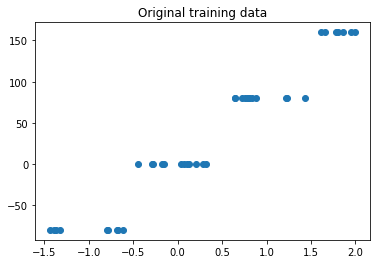

In [135]:
plot_fit(train_df[:,0], y = None, c_pred=train_df[:,1],c_ref=None, legend=None, hidden_layers=None)

Zadanie będzie rozwiązywane z następującymi parametrami:
- architektura z dwiema warstwami składającymi się z 15 i 10 neuronów,
- logistyczna funkcja aktywacji w warstwach ukrytych,
- podejście niebatchowe (mała liczba wzorców w zbiorze treningowym)
- rozmiar zbioru walidacyjnego: 0.2 rozmiaru zbioru treningowego - domyślna wartość w tym i kolejnych przykładach
- optymalizacja: `RMSProp` z parametrem 0.99
- współczynnik uczenia: 0.05
- współczynnik regularyzacji: 0.1
- maksymalna liczba epok: 1500

Value of loss function on validation subset after 885 epochs (378.4) is at least 10% higher than after 644 (232.3).
Moreover, last 5 epochs' losses were rising.
Training stopped and weights after 644 epochs are considered.


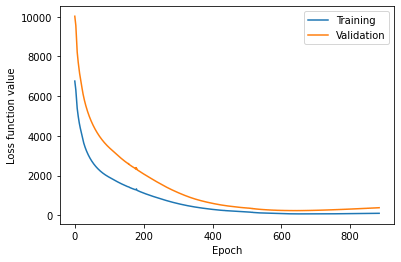

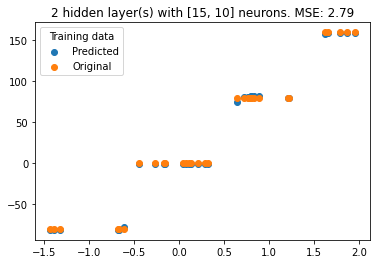

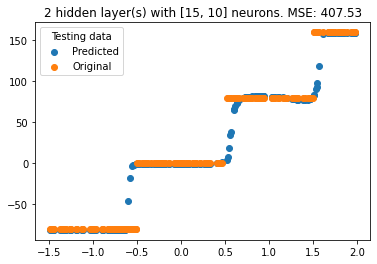

In [22]:
train_plot_wrap(train_data_multimodal, train_df[:,1], test_data_multimodal, test_df[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='sigmoid',
                regularization_rate = 0.1,last_activation_fun = 'linear',learning_rate=0.05, classification=False,
                optimisation='rmsprop', optimisation_param = 0.99, btch=100)

Próba bez dodatkowej regularyzacji - współczynnik regularyzacji równy 0:

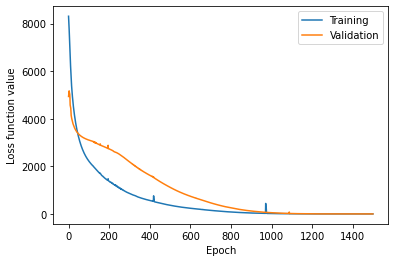

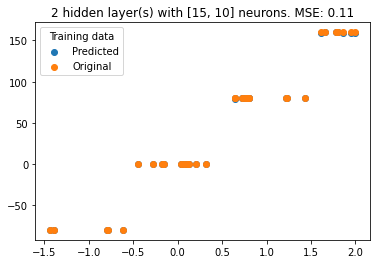

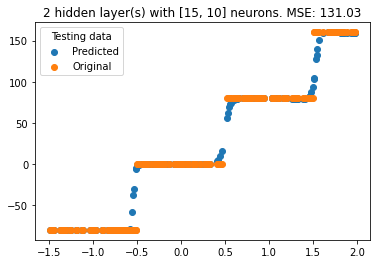

In [24]:
train_plot_wrap(train_data_multimodal, train_df[:,1], test_data_multimodal, test_df[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='sigmoid',
                regularization_rate = 0,
                val_size = 0.2,
                last_activation_fun = 'linear',learning_rate=0.05, classification=False,
                optimisation='rmsprop', optimisation_param = 0.99, btch=100)

Próba bez zbioru walidacyjnego - część zbioru treningowego przeznaczonego wyłącznie na walidację równa 0.

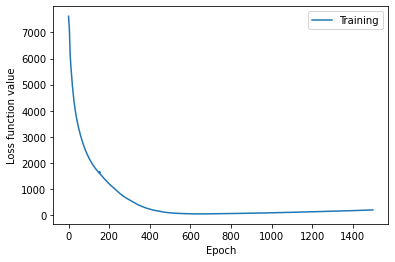

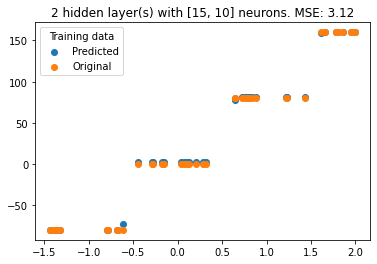

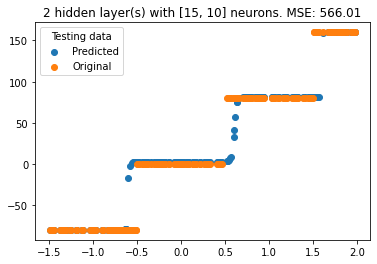

In [25]:
train_plot_wrap(train_data_multimodal, train_df[:,1], test_data_multimodal, test_df[:, 1], hidden_layers=[15, 10],
                n_inputs=1, n_outputs=1, epochs = 1500, hidden_activation_fun='sigmoid',
                regularization_rate = 0.1,
                val_size = 0,
                last_activation_fun = 'linear',learning_rate=0.05, classification=False,
                optimisation='rmsprop', optimisation_param = 0.99, btch=100)

W powyższym zadaniu regresji porównano 3 metody zapobiegania przeuczeniu: korzystające z regularyzacji, zbioru walidacyjnego oraz obu rozwiązań. Najlepiej w sensie miary MSE na zbiorze testowym zaprezentowała się metoda bez regularyzacji wag. Warto zauważyć, że w pierwszym przypadku proces trenowania zakończył się po 644 epokach.

# 2. zbiór danych - `rings5-sparse`

In [26]:
train_df2 = pd.read_csv('../dane/mio1/classification/rings5-sparse-training.csv', dtype='float128').to_numpy()
test_df2 = pd.read_csv('../dane/mio1/classification/rings5-sparse-test.csv', dtype='float128').to_numpy()

train_labels2 = np.zeros((len(train_df2), 5))

for i, j in enumerate(train_df2[:,2]):
    train_labels2[i, int(j)] = 1
    
train_data_rings5 = np.array([
    np.array([[x_i, y_i, 0, 0, 0], [c_1, c_2, c_3, c_4, c_5]])
    for x_i, y_i, c_1, c_2, c_3, c_4, c_5 in zip(
        train_df2[:,0],
        train_df2[:,1],
        train_labels2[:,0],
        train_labels2[:,1],
        train_labels2[:,2],
        train_labels2[:,3],
        train_labels2[:,4])])

test_labels2 = np.zeros((len(test_df2), 5))

for i, j in enumerate(test_df2[:,2]):
    test_labels2[i, int(j)] = 1

test_data_rings5 = np.array([
    np.array([[x_i, y_i, 0, 0, 0], [l1, l2, l3, l4, l5]])
    for x_i, y_i, l1, l2, l3, l4, l5 in zip(
        test_df2[:,0],
        test_df2[:,1],
        test_labels2[:,0],
        test_labels2[:,1],
        test_labels2[:,2],
        test_labels2[:,3],
        test_labels2[:,4])])


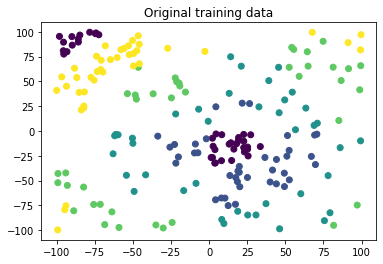

In [27]:
plot_fit(train_df2[:,0], y = train_df2[:,1], c_pred=train_df2[:,2], c_ref=None, legend=None, hidden_layers=None)

Zbiór danych cechuje się wysokim niezbalansowaniem danych oraz - jak sama nazwa wskazuje - rzadkością.
- Architekrua: 2 warstwy z 25 i 20 neuronami,
- współczynnik regularyzacji: 0.00005,
- współczynnik uczenia: 0.005

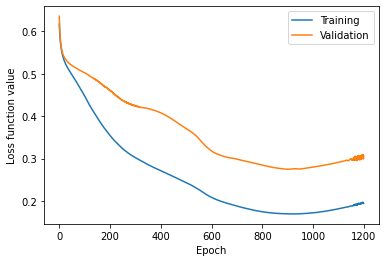

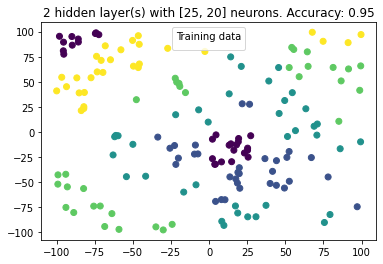

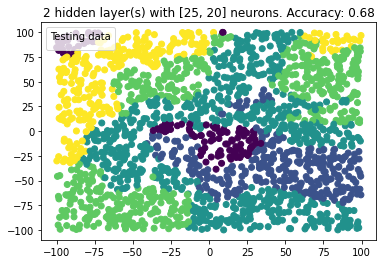

In [30]:
train_plot_wrap(train_data_rings5, train_df2[:,2], test_data_rings5, test_df2[:, 2], hidden_layers=[25, 20],
                n_outputs=5, epochs = 1200, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
                regularization_rate = 0.00005, learning_rate = 0.005, 
                optimisation='rmsprop', optimisation_param = 0.99)

Wersja bez regularyzacji:

Value of loss function on validation subset after 910 epochs (0.2) is at least 10% higher than after 905 (0.2).
Moreover, last 5 epochs' losses were rising.
Training stopped and weights after 905 epochs are considered.


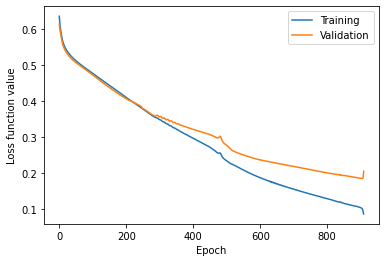

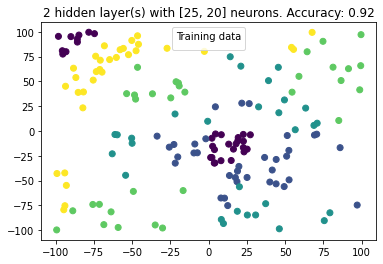

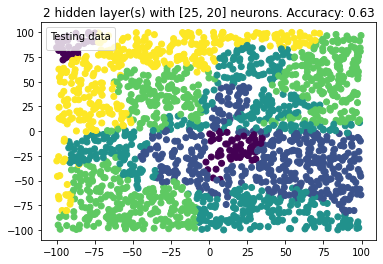

In [35]:
train_plot_wrap(train_data_rings5, train_df2[:,2], test_data_rings5, test_df2[:, 2], hidden_layers=[25, 20],
                n_outputs=5, epochs = 1200, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
                regularization_rate = 0, learning_rate = 0.005, 
                optimisation='rmsprop', optimisation_param = 0.99)

Wersja bez zbioru walidacyjnego:

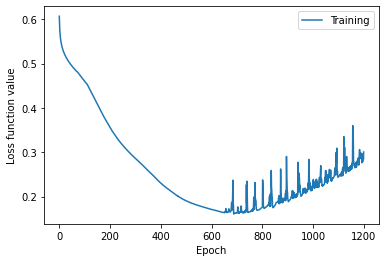

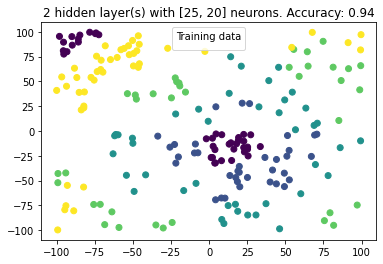

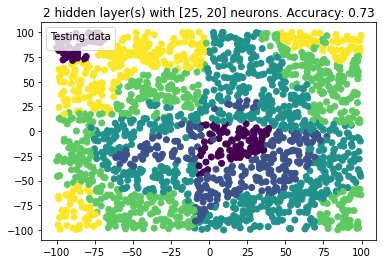

In [36]:
train_plot_wrap(train_data_rings5, train_df2[:,2], test_data_rings5, test_df2[:, 2], hidden_layers=[25, 20],
                n_outputs=5, epochs = 1200, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
                regularization_rate = 0.00005, learning_rate = 0.005, val_size = 0,
                optimisation='rmsprop', optimisation_param = 0.99)

Funkcja straty na zbiorze treningowym znacznie wzrosła po ok. 620 epokach. Sprawdźmy jak zaprezentuje się model o takiej długości trenowania:

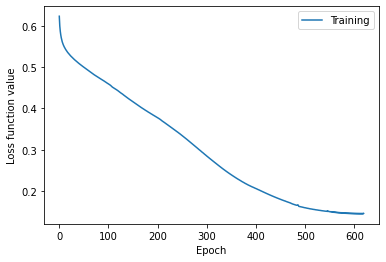

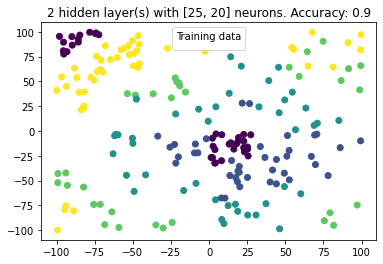

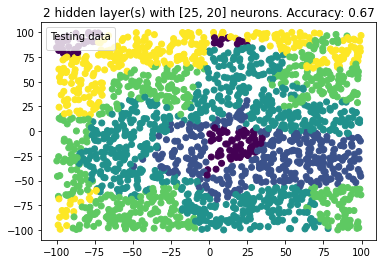

In [37]:
train_plot_wrap(train_data_rings5, train_df2[:,2], test_data_rings5, test_df2[:, 2], hidden_layers=[25, 20],
                n_outputs=5, epochs = 620, hidden_activation_fun='sigmoid', last_activation_fun = 'softmax',
                regularization_rate = 0.00005, learning_rate = 0.005, val_size = 0,
                optimisation='rmsprop', optimisation_param = 0.99)

Z zadaniem klasyfikacji najlepiej poradziła sobie sieć trenowana bez zbioru walidacyjnego z 1500 epokami. Najwyraźniej większa liczba wzorców uczących korzystniej wpłynęła na uczenie.


# 3. zbiór danych - `rings3-balance`

In [39]:
train_df3 = pd.read_csv('../dane/mio1/classification/rings3-balance-training.csv', dtype='float128').to_numpy()
test_df3 = pd.read_csv('../dane/mio1/classification/rings3-balance-test.csv', dtype='float128').to_numpy()

train_labels3 = np.zeros((len(train_df3), 3))

for i, j in enumerate(train_df3[:,2]):
    train_labels3[i, int(j)] = 1
    
train_data_rings3 = np.array([
    np.array([[x_i, y_i, 0], [c_1, c_2, c_3]])
    for x_i, y_i, c_1, c_2, c_3 in zip(
        train_df3[:,0],
        train_df3[:,1],
        train_labels3[:,0],
        train_labels3[:,1],
        train_labels3[:,2])])

test_labels3 = np.zeros((len(test_df3), 3))

for i, j in enumerate(test_df3[:,2]):
    test_labels3[i, int(j)] = 1

test_data_rings3 = np.array([
    np.array([[x_i, y_i, 0], [l1, l2, l3]])
    for x_i, y_i, l1, l2, l3 in zip(
        test_df3[:,0],
        test_df3[:,1],
        test_labels3[:,0],
        test_labels3[:,1],
        test_labels3[:,2])])

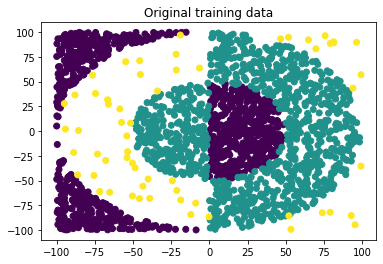

In [40]:
plot_fit(train_df3[:,0], y = train_df3[:,1], c_pred=train_df3[:,2], c_ref=None, legend=None, hidden_layers=None)

Ponownie wysokie niezbalansowanie oraz rzadkość, szczególnie jednej z klas.

- Architektura: 2 warstwy z 25 i 20 neuronami,
- Funkcja aktywacji warstw ukrytych: tangens hiperboliczny,
- współczynnik regularyzacji: 0.00001,
- współczynnik uczenia: 0.0008
- współczynnik optymalizacji: 0.95

Value of loss function on validation subset after 210 epochs (0.0) is at least 10% higher than after 196 (0.0).
Moreover, last 5 epochs' losses were rising.
Training stopped and weights after 196 epochs are considered.


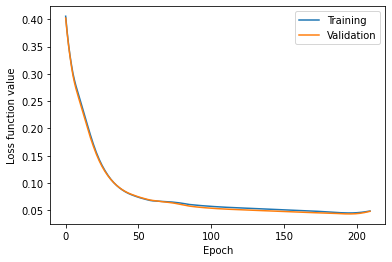

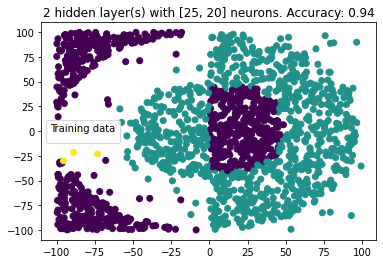

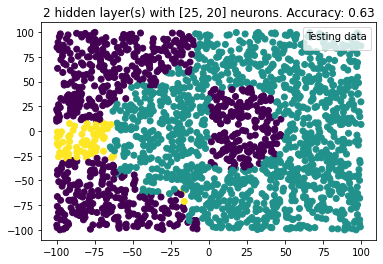

In [42]:
train_plot_wrap(train_data_rings3, train_df3[:,2], test_data_rings3, test_df3[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 400, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0.00001, learning_rate = 0.0008,
                optimisation='rmsprop', optimisation_param = 0.95)

Wersja bez regularyzacji wag:

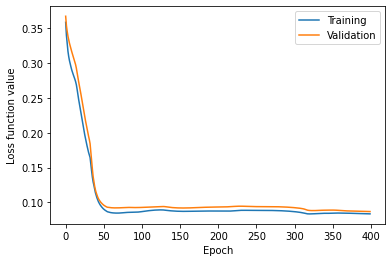

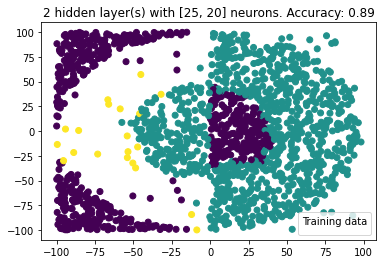

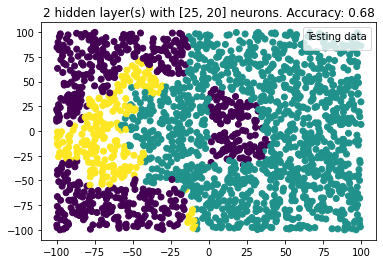

In [43]:
train_plot_wrap(train_data_rings3, train_df3[:,2], test_data_rings3, test_df3[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 400, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0, learning_rate = 0.0008,
                optimisation='rmsprop', optimisation_param = 0.95)

Wersja bez zbioru walidacyjnego:

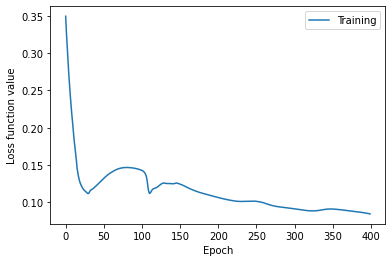

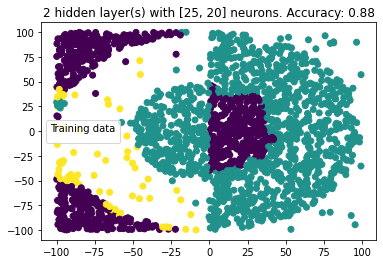

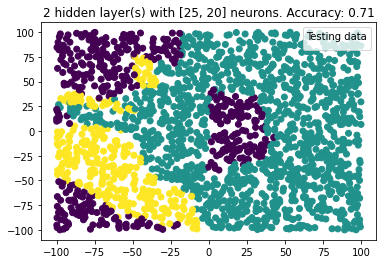

In [45]:
train_plot_wrap(train_data_rings3, train_df3[:,2], test_data_rings3, test_df3[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 400, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0.00001, learning_rate = 0.0008, val_size = 0,
                optimisation='rmsprop', optimisation_param = 0.95)

Niewielka liczba obserwacji pochądzących z jednej z klas stanowiła nie lada wyzwanie dla sieci. Najlepiej z problemem poradziła sobie wersja bez zbioru walidacyjnego, która poprawnie wyznaczyła tylko część pól należących do tej małolicznej w zbiorze treningowym klasy.
# 4. zbiór danych - `xor3-balance`

In [6]:
train_df4 = pd.read_csv('../dane/mio1/classification/xor3-balance-training.csv', dtype='float128').to_numpy()
test_df4 = pd.read_csv('../dane/mio1/classification/xor3-balance-test.csv', dtype='float128').to_numpy()

train_labels4 = np.zeros((len(train_df4), 2))

for i, j in enumerate(train_df4[:,2]):
    train_labels4[i, int(j)] = 1
    
train_data_xor3 = np.array([
    np.array([[x_i, y_i], [c_1, c_2]])
    for x_i, y_i, c_1, c_2 in zip(
        train_df4[:,0],
        train_df4[:,1],
        train_labels4[:,0],
        train_labels4[:,1])])

test_labels4 = np.zeros((len(test_df4), 2))

for i, j in enumerate(test_df4[:,2]):
    test_labels4[i, int(j)] = 1

test_data_xor3 = np.array([
    np.array([[x_i, y_i], [l1, l2]])
    for x_i, y_i, l1, l2 in zip(
        test_df4[:,0],
        test_df4[:,1],
        test_labels4[:,0],
        test_labels4[:,1])])

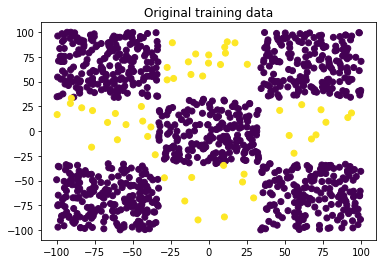

In [7]:
plot_fit(train_df4[:,0], y = train_df4[:,1], c_pred=train_df4[:,2], c_ref=None, legend=None, hidden_layers=None)

- Złożona architektura sieci: 3 warstwy z 50, 40 i 30 neuronami,
- maksymalna liczba epok: 1000,
- tanh jako funkcja aktywacji warstw ukrytych,
- współczynnik regularyzacji: 0.000012,
- współczynnik uczenia: 0.0006.

Value of loss function on validation subset after 35 epochs (0.0) is at least 10% higher than after 27 (0.0).
Moreover, last 5 epochs' losses were rising.
Training stopped and weights after 27 epochs are considered.


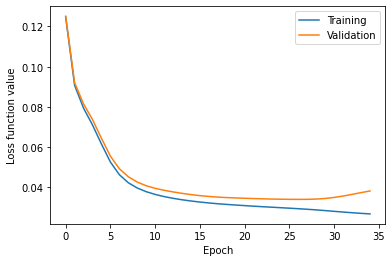

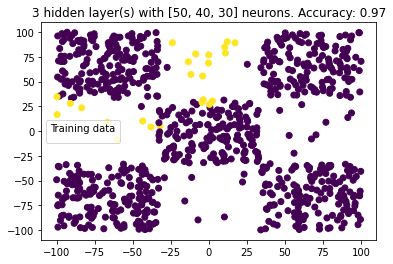

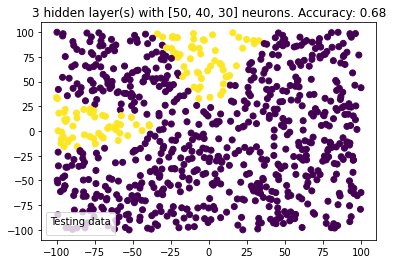

In [49]:
train_plot_wrap(train_data_xor3, train_df4[:,2], test_data_xor3, test_df4[:, 2], hidden_layers=[50, 40, 30],
                n_outputs=2, epochs = 1000, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0.000012, learning_rate = 0.0006,
                #optimisation=None)
                optimisation='rmsprop', optimisation_param = 0.95)

Wersja bez regularyzacji:

Value of loss function on validation subset after 864 epochs (0.1) is at least 10% higher than after 789 (0.0).
Moreover, last 5 epochs' losses were rising.
Training stopped and weights after 789 epochs are considered.


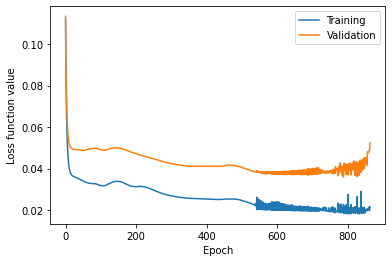

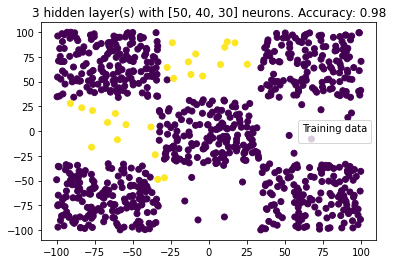

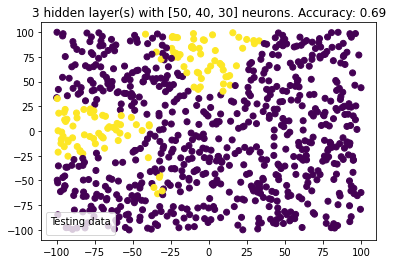

In [50]:
train_plot_wrap(train_data_xor3, train_df4[:,2], test_data_xor3, test_df4[:, 2], hidden_layers=[50, 40, 30],
                n_outputs=2, epochs = 1000, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0, learning_rate = 0.0006,
                #optimisation=None)
                optimisation='rmsprop', optimisation_param = 0.95)

Wersja bez zbioru walidacyjnego z 1400 epokami:

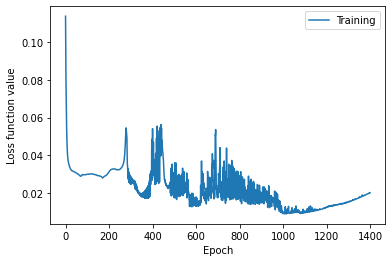

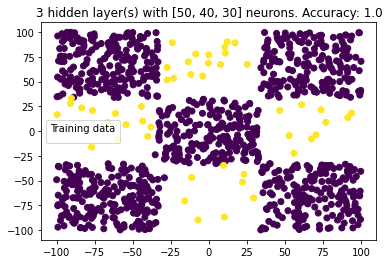

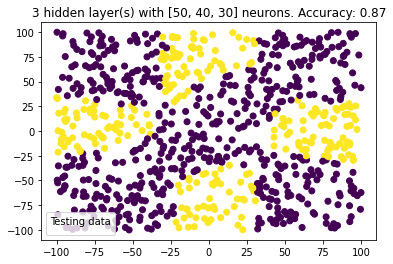

In [14]:
train_plot_wrap(train_data_xor3, train_df4[:,2], test_data_xor3, test_df4[:, 2], hidden_layers=[50, 40, 30],
                n_outputs=2, epochs = 1400, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0.000012, learning_rate = 0.0006, val_size = 0,
                #optimisation=None)
                optimisation='rmsprop', optimisation_param = 0.95)

Wersja bez zbioru walidacyjnego z 1400 epokami, ze zmiejszoną wartością współczynnika uczenia:

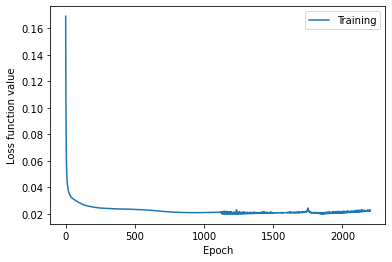

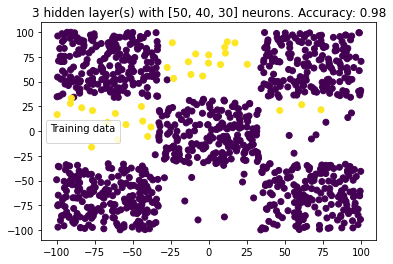

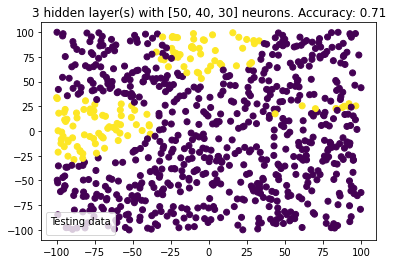

In [15]:
train_plot_wrap(train_data_xor3, train_df4[:,2], test_data_xor3, test_df4[:, 2], hidden_layers=[50, 40, 30],
                n_outputs=2, epochs = 2200, hidden_activation_fun='tanh', last_activation_fun = 'softmax',
                regularization_rate = 0.000012, learning_rate = 0.0002, val_size = 0,
                #optimisation=None)
                optimisation='rmsprop', optimisation_param = 0.95)

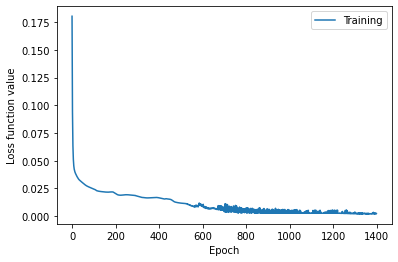

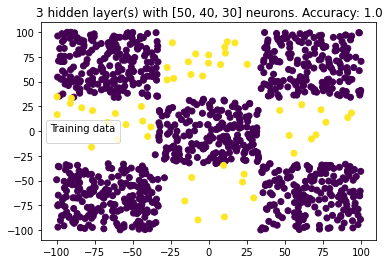

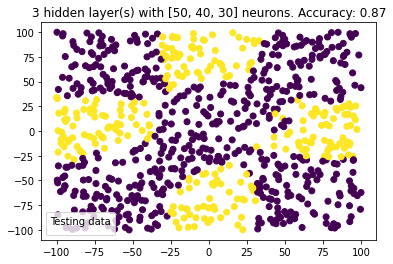

In [16]:
#Eksperyment: logistyczna funkcja aktywacji na wyjściu - stabilniejsze rozwiązanie, wspomniane w sprawozdaniu.
train_plot_wrap(train_data_xor3, train_df4[:,2], test_data_xor3, test_df4[:, 2], hidden_layers=[50, 40, 30],
                n_outputs=2, epochs = 1400, hidden_activation_fun='tanh', last_activation_fun = 'sigmoid',
                regularization_rate = 0.000012, learning_rate = 0.0006, val_size = 0,
                #optimisation=None)
                optimisation='rmsprop', optimisation_param = 0.95)

Pomimo wielu perturbacji, sieć bez wydzielonego zbioru walidacyjnego osiągnęla zdecydowanie najlepsze rezultaty poprawnie identyfikując 4 obszary należące do klasy o mniejszej liczności, co nie udało się pozostałym wersjom.

# Podsumowanie

W świetle przeprowadzonych eksperymentów można stwierdzić, że mechanizmy zapobiegające przeuczeniu są istotnym elementem w procesie trenowania sieci. W przeprowadzonych testach z zadaniem klasyfikacji najlepiej poradził sobie mechanizm regularyzacji wag bez stosowania zbioru walidacyjnego, który to okazał się pomocny tylko przy zadaniu regresji.